# Cleaning train and test data

### Importing libraries

In [1]:
import pandas as pd 
import numpy as np
from os import listdir, stat, mkdir
import matplotlib.pyplot as plt
%matplotlib inline
pd.options.mode.chained_assignment = None

### Defining paths to data and to cleaned data directory

In [2]:
path = "C:/Users/Marie/Desktop/MSc DSBA/4. Machine Learning/3. Project/"
directory = 'clean_data/'
print(listdir(path))

['.ipynb_checkpoints', 'clean_data', 'Dealing with sessions.ipynb', 'Github', 'sessions.csv', 'sessions_cleaned', 'test_users.csv', 'train_users_2.csv', 'variables.xlsx', '~$variables.xlsx']


### Creating cleaned data directory

In [3]:
try :
    stat(path + directory)
except: 
    mkdir(path + directory)

### Loading data

In [4]:
train = pd.read_csv(path + 'train_users_2.csv', na_values=['-unknown-'])
train['user_id'] = train['id']
train = train.drop(['id', 'date_first_booking'], axis = 1)

In [5]:
test = pd.read_csv(path + 'test_users.csv', na_values=['-unknown-'])
test['user_id'] = test['id']
test = test.drop(['id', 'date_first_booking'], axis = 1)

### Concatenating train and test data

In [6]:
data = pd.concat([train, test]).set_index('user_id', drop = True)

### Defining target dataset

In [7]:
targets = data['country_destination']
data = data.drop('country_destination', axis = 1)

In [8]:
data.head()

,affiliate_channel,affiliate_provider,age,date_account_created,first_affiliate_tracked,first_browser,first_device_type,gender,language,signup_app,signup_flow,signup_method,timestamp_first_active
user_id,,,,,,,,,,,,,
gxn3p5htnn,direct,direct,NaN,2010-06-28,untracked,Chrome,Mac Desktop,NaN,en,Web,0,facebook,20090319043255
820tgsjxq7,seo,google,38.0,2011-05-25,untracked,Chrome,Mac Desktop,MALE,en,Web,0,facebook,20090523174809
4ft3gnwmtx,direct,direct,56.0,2010-09-28,untracked,IE,Windows Desktop,FEMALE,en,Web,3,basic,20090609231247
bjjt8pjhuk,direct,direct,42.0,2011-12-05,untracked,Firefox,Mac Desktop,FEMALE,en,Web,0,facebook,20091031060129
87mebub9p4,direct,direct,41.0,2010-09-14,untracked,Chrome,Mac Desktop,NaN,en,Web,0,basic,20091208061105


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 275547 entries, gxn3p5htnn to 9uqfg8txu3
Data columns (total 13 columns):
affiliate_channel          275547 non-null object
affiliate_provider         275547 non-null object
age                        158681 non-null float64
date_account_created       275547 non-null object
first_affiliate_tracked    269462 non-null object
first_browser              231153 non-null object
first_device_type          275547 non-null object
gender                     146067 non-null object
language                   275546 non-null object
signup_app                 275547 non-null object
signup_flow                275547 non-null int64
signup_method              275547 non-null object
timestamp_first_active     275547 non-null int64
dtypes: float64(1), int64(2), object(10)
memory usage: 29.4+ MB


### Dealing with temporal data

In [10]:
def format_timestamp(x):
    x = str(x)
    return x[:4]+'-'+x[4:6] +'-'+x[6:8]+' '+x[8:10]+':'+x[10:12]+':'+x[12:]

In [11]:
def transform_cyclical_data(x):
    day = x.day
    month = x.month
    hour = x.time().hour*60+x.time().minute
    day_cos = np.cos(day*2/30*np.pi)
    day_sin = np.sin(day*2/30*np.pi)
    hour_sin = np.sin(hour*2*np.pi/(24*60))
    hour_cos = np.cos(hour*2*np.pi/(24*60))
    month_cos = np.cos(month*2*np.pi/12)
    month_sin = np.sin(month*2*np.pi/12)
    week_day = x.weekday()
    week_day_cos = np.cos(week_day*2*np.pi/7)
    week_day_sin = np.sin(week_day*2*np.pi/7)
    return [day_cos, day_sin, month_cos, month_sin, hour_cos, hour_sin, week_day_cos, week_day_sin]

In [12]:
data.timestamp_first_active = pd.to_datetime(data.timestamp_first_active.apply(format_timestamp), format = '%Y-%m-%d %H:%M:%S')
data.date_account_created = pd.to_datetime(data.date_account_created)

In [13]:
time_cols = ['timestamp_first_active', 'date_account_created']

for col in time_cols :
    data[col] = pd.to_datetime(data[col]).apply(transform_cyclical_data)
    data[col + '_day_cos'] = data[col].apply(lambda x: x[0])
    data[col + '_day_sin'] = data[col].apply(lambda x: x[1])
    data[col + '_month_cos'] = data[col].apply(lambda x: x[2])
    data[col + '_month_sin'] = data[col].apply(lambda x: x[3])
    data[col + '_hour_cos'] = data[col].apply(lambda x: x[4])
    data[col + '_hour_sin'] = data[col].apply(lambda x: x[5])
    data[col + '_wkday_cos'] = data[col].apply(lambda x: x[6])
    data[col + '_wkday_sin'] = data[col].apply(lambda x: x[7])
    data.drop([col], axis = 1, inplace = True)
    print(col, 'done')

timestamp_first_active done
date_account_created done


### Filling missing language variable

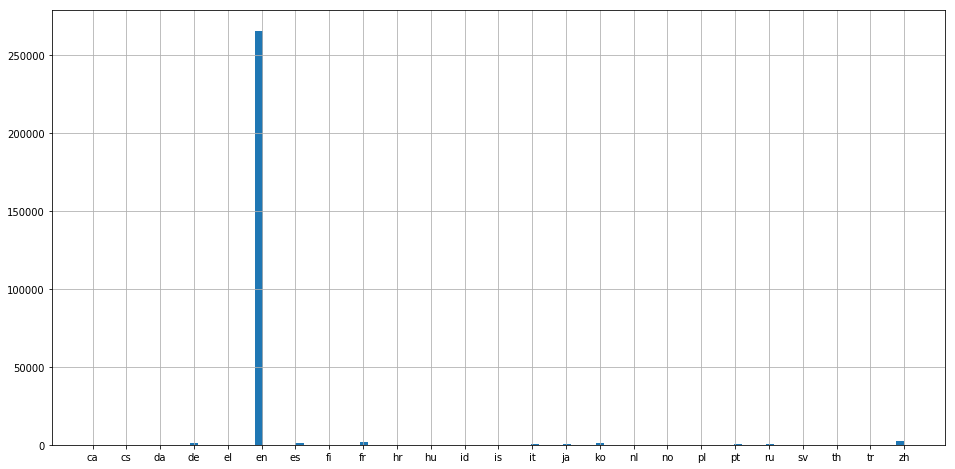

In [14]:
data.language.hist(figsize = (16,8), bins = 100 )
plt.show()
# replacing the missing value in language by english 
data.language.fillna(value = 'en', inplace = True)

### Filling first affiliate tracked variable

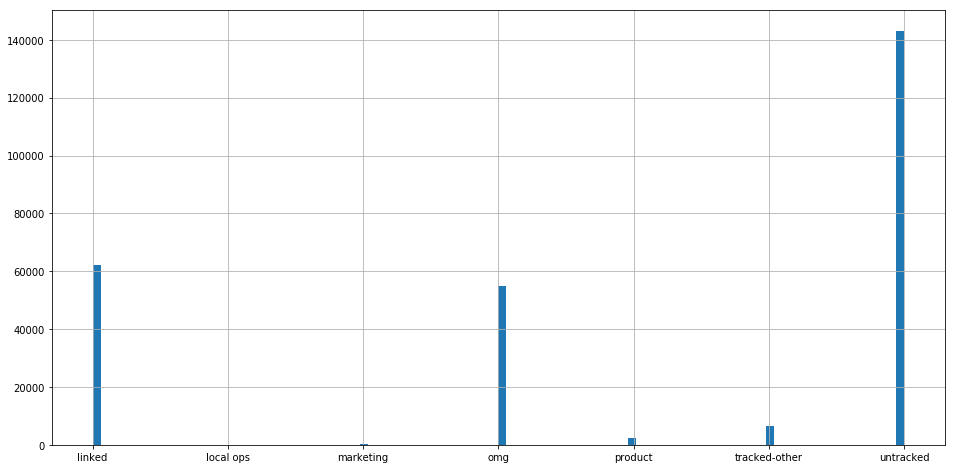

In [15]:
data.first_affiliate_tracked.hist(figsize = (16,8), bins=100)
plt.show()
# it seems logical to fill the first affiliate tracked non available values with 'untracked'
data.first_affiliate_tracked.fillna('untracked', inplace = True)

### Dealing with first browser variable

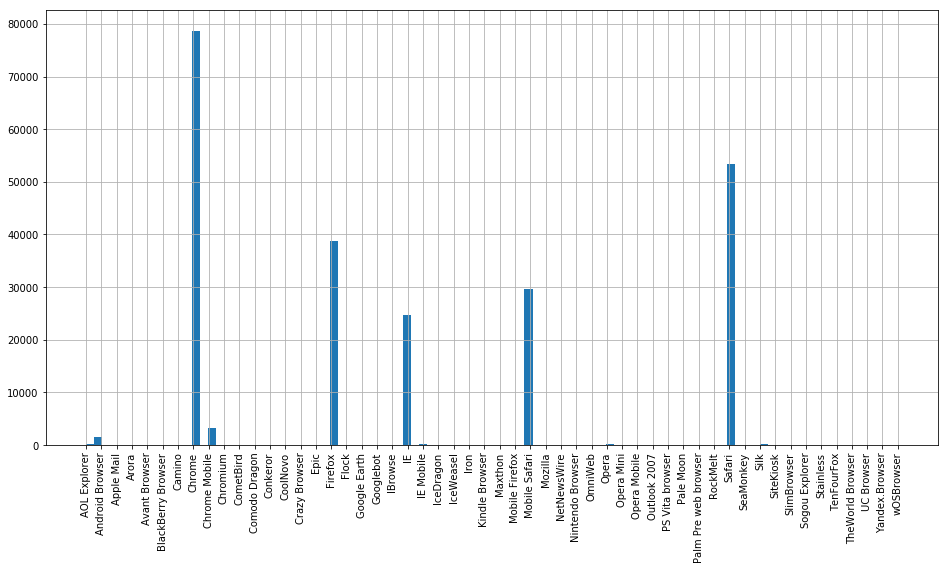

In [16]:
data.first_browser.hist(bins= 100, figsize = (16,8))
plt.xticks(rotation = 90)
plt.show()
# there are a lot of different values, so we will simply keep the most important and discard the other as 'other', includint na values
most_common_browser = data.first_browser.value_counts().sort_values( ascending = False)[:9].index
data.first_browser = data.first_browser.apply(lambda x: x if x in most_common_browser else 'other')

### Keeping a variable to split data into train and test

In [17]:
data['train'] = targets.notnull()*1

### Creating dummy variables

In [18]:
col_obj = data.columns[data.dtypes == 'object']
for col in col_obj:
    data = pd.get_dummies(data, columns=[col], prefix = col + '_')

In [19]:
pd.DataFrame(targets).to_csv(path + directory + 'targets_flat.csv', index = True)
targets = pd.get_dummies(targets)

### Saving data in csv files

In [20]:
data[data['train']==1].drop('train',axis = 1).to_csv(path + directory + 'train.csv', index = True)
data[data['train']==0].drop('train',axis = 1).to_csv(path + directory + 'test.csv', index = True)

In [21]:
targets.to_csv(path + directory + 'targets.csv', index = True)